In [1]:
import os
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis
from scipy.signal import hilbert

LABELS = {
    "normal": "A",
    "imbalance": "B",
    "horizontal-misalignment": "C",
    "vertical-misalignment": "D",
    "overhang/ball_fault": "E",
    "overhang/cage_fault": "F",
    "overhang/outer_race": "G",
    "underhang/ball_fault": "H",
    "underhang/cage_fault": "I",
    "underhang/outer_race": "J"
}

DATASET_PATH = "/kaggle/input/mafaulda-full/mafaulda"

def get_class_files(dataset_path):
    class_files = {label: [] for label in LABELS.values()}
    
    for root, _, files in os.walk(dataset_path):
        for folder, label in LABELS.items():
            if folder in root:
                csv_files = [os.path.join(root, f) for f in files if f.endswith('.csv')]
                class_files[label].extend(csv_files)
    
    return {label: files for label, files in class_files.items() if files}

def extract_features(signal, wavelet='bior3.1', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    approx_coeff = coeffs[0]
    detail_coeffs = coeffs[1:]
    
    features = {
        'mean_approx': np.mean(approx_coeff),
        'std_approx': np.std(approx_coeff),
        'var_approx': np.var(approx_coeff),
        'rms_approx': np.sqrt(np.mean(np.square(approx_coeff))),
        'kurt_approx': kurtosis(approx_coeff),
        'skew_approx': skew(approx_coeff),
        'zcr_approx': np.sum(np.abs(np.diff(np.sign(approx_coeff)))) / len(approx_coeff),
        'mcr_approx': np.sum(np.abs(np.diff(np.sign(approx_coeff - np.mean(approx_coeff))))) / len(approx_coeff),
        'entropy_approx': -np.sum(np.histogram(approx_coeff, bins=10, density=True)[0] * np.log2(np.histogram(approx_coeff, bins=10, density=True)[0] + 1e-6))
    }
    
    for i, d_coeff in enumerate(detail_coeffs, 1):
        features[f'mean_d{i}'] = np.mean(d_coeff)
        features[f'std_d{i}'] = np.std(d_coeff)
        features[f'var_d{i}'] = np.var(d_coeff)
        features[f'rms_d{i}'] = np.sqrt(np.mean(np.square(d_coeff)))
        features[f'kurt_d{i}'] = kurtosis(d_coeff)
        features[f'skew_d{i}'] = skew(d_coeff)
        features[f'entropy_d{i}'] = -np.sum(np.histogram(d_coeff, bins=10, density=True)[0] * np.log2(np.histogram(d_coeff, bins=10, density=True)[0] + 1e-6))
    
    analytic_signal = hilbert(approx_coeff)
    features['hilbert_mean'] = np.mean(np.abs(analytic_signal))
    features['hilbert_std'] = np.std(np.abs(analytic_signal))
    
    return features

# Load data and extract features
def load_and_preprocess_data(dataset_path):
    class_files = get_class_files(dataset_path)
    all_features = []
    all_labels = []
    
    for label, files in class_files.items():
        for file in files:
            df = pd.read_csv(file, header=None)
            df = df.iloc[:, :-1]  # Removing last column (microphone data)
            
            combined_features = {}
            
            for col in range(df.shape[1]):
                signal = df.iloc[:, col].values
                features = extract_features(signal)
                
                for key, value in features.items():
                    combined_features[f'col{col+1}_{key}'] = value
            
            combined_features['label'] = label 
            all_features.append(combined_features)
            all_labels.append(label)
    
    df_features = pd.DataFrame(all_features)
    return df_features.drop(columns=['label']), df_features['label']


if __name__ == "__main__":

    X, y = load_and_preprocess_data(DATASET_PATH)
    df_final = pd.DataFrame(X, columns=X.columns)
    df_final['label'] = y
    df_final.to_csv("/kaggle/working/mafaulda_processed.csv", index=False)
    
    print("Feature extraction completed. Processed data saved as 'mafaulda_processed.csv'.")


Feature extraction completed. Processed data saved as 'mafaulda_processed.csv'.


In [4]:
df = pd.read_csv('mafaulda_processed.csv')
df.shape

(1951, 274)

In [7]:
import numpy as np
import pandas as pd
import joblib
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

# Load processed dataset
df = pd.read_csv("mafaulda_processed.csv")

# Extract features and labels
X = df.drop(columns=['label'])
y = df['label']

In [18]:
# Create binary labels: "Normal" (A) = 0, "Faulty" (B to J) = 1
y_binary = np.where(y == "A", 0, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Apply SMOTE for class balance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_binary)

# Train LGBMClassifier (Binary)
binary_model = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metric='binary_logloss',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    n_estimators=100,
    random_state=42,
    verbose = -1
)

binary_model.fit(X_resampled, y_resampled)

# Save the model
joblib.dump(binary_model, "lgbm_binary_model.joblib")

# Evaluate
y_pred = binary_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Binary Model Accuracy: {accuracy:.4f}")

Binary Model Accuracy: 1.0000


In [20]:
# Remove "A" (Normal) from dataset
df_faulty = df[df['label'] != "A"]

# Extract features and labels
X_faulty = df_faulty.drop(columns=['label'])
y_faulty = df_faulty['label']

# Encode labels (B to J)
label_encoder = LabelEncoder()
y_faulty_encoded = label_encoder.fit_transform(y_faulty)

# Train-test split
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_faulty, y_faulty_encoded, test_size=0.2, random_state=42, stratify=y_faulty_encoded)

# Apply SMOTE for balancing B to J
X_resampled_faulty, y_resampled_faulty = SMOTE(random_state=42).fit_resample(X_train_f, y_train_f)

# Train LGBMClassifier (Multi-class)
multi_model = LGBMClassifier(
    boosting_type='gbdt',
    objective='multiclass',
    num_class=len(label_encoder.classes_),
    metric='multi_logloss',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    n_estimators=100,
    random_state=42,
    verbose = -1
)

multi_model.fit(X_resampled_faulty, y_resampled_faulty)

# Save model and encoders
joblib.dump(multi_model, "lgbm_multi_model.joblib")
joblib.dump(label_encoder, "label_encoder.joblib")

# Evaluate
y_pred_f = multi_model.predict(X_test_f)
accuracy_f = accuracy_score(y_test_f, y_pred_f)
print(f"Multi-class Model Accuracy: {accuracy_f:.4f}")


🔹 Multi-class Model Accuracy: 0.9948


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


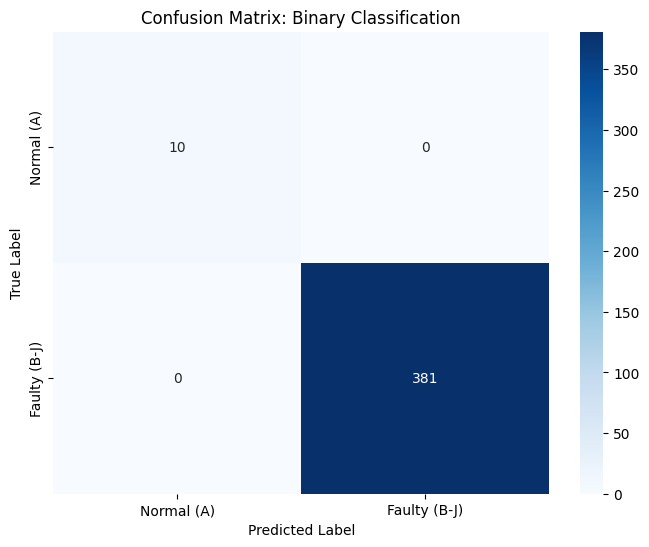

In [17]:
# Define labels
binary_labels = ["Normal (A)", "Faulty (B-J)"]

# Plot confusion matrix for binary classification
plot_confusion_matrix(y_test, y_pred, binary_labels, "Confusion Matrix: Binary Classification")


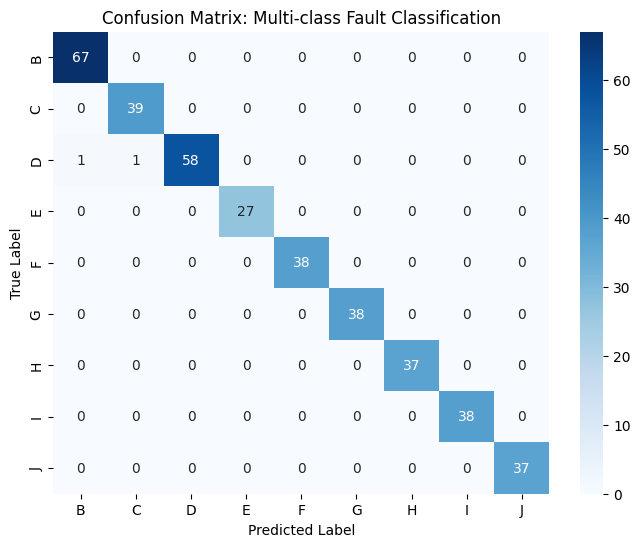

In [21]:
# Label names for faults (B to J)
multi_labels = label_encoder.classes_

# Plot confusion matrix for multi-class classification
plot_confusion_matrix(y_test_f, y_pred_f, multi_labels, "Confusion Matrix: Multi-class Fault Classification")


In [34]:
import numpy as np
import pandas as pd
import pywt
import joblib
from scipy.stats import skew, kurtosis
from scipy.signal import hilbert

def extract_features(signal, wavelet='bior3.1', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    approx_coeff = coeffs[0]
    detail_coeffs = coeffs[1:]
    
    features = {}
    
    features['mean_approx'] = np.mean(approx_coeff)
    features['std_approx'] = np.std(approx_coeff)
    features['var_approx'] = np.var(approx_coeff)
    features['rms_approx'] = np.sqrt(np.mean(np.square(approx_coeff)))
    features['kurt_approx'] = kurtosis(approx_coeff)
    features['skew_approx'] = skew(approx_coeff)
    features['zcr_approx'] = np.sum(np.abs(np.diff(np.sign(approx_coeff)))) / len(approx_coeff)
    features['mcr_approx'] = np.sum(np.abs(np.diff(np.sign(approx_coeff - np.mean(approx_coeff))))) / len(approx_coeff)
    features['entropy_approx'] = -np.sum(np.histogram(approx_coeff, bins=10, density=True)[0] * np.log2(np.histogram(approx_coeff, bins=10, density=True)[0] + 1e-6))
    
    for i, d_coeff in enumerate(detail_coeffs, 1):
        features[f'mean_d{i}'] = np.mean(d_coeff)
        features[f'std_d{i}'] = np.std(d_coeff)
        features[f'var_d{i}'] = np.var(d_coeff)
        features[f'rms_d{i}'] = np.sqrt(np.mean(np.square(d_coeff)))
        features[f'kurt_d{i}'] = kurtosis(d_coeff)
        features[f'skew_d{i}'] = skew(d_coeff)
        features[f'entropy_d{i}'] = -np.sum(np.histogram(d_coeff, bins=10, density=True)[0] * np.log2(np.histogram(d_coeff, bins=10, density=True)[0] + 1e-6))
    
    analytic_signal = hilbert(approx_coeff)
    features['hilbert_mean'] = np.mean(np.abs(analytic_signal))
    features['hilbert_std'] = np.std(np.abs(analytic_signal))
    
    return features

def preprocess_csv(file_path):
    df = pd.read_csv(file_path, header=None)
    df = df.iloc[:, :-1]
    
    combined_features = {}
    for col in range(df.shape[1]):
        signal = df.iloc[:, col].values
        features = extract_features(signal)
        
        for key, value in features.items():
            combined_features[f'col{col+1}_{key}'] = value
    
    return pd.DataFrame([combined_features])

def predict_faults(df_features):
    label_encoder = joblib.load("label_encoder.joblib")
    binary_model = joblib.load("lgbm_binary_model.joblib")
    multi_model = joblib.load("lgbm_multi_model.joblib")
    print(df_features.shape)
    binary_prediction = binary_model.predict(df_features)
    
    if binary_prediction[0] == 0:
        print("Normal")
    else:
        multi_prediction = multi_model.predict(df_features)
        decoded_label = label_encoder.inverse_transform(multi_prediction)
        label_mapping = {
            "A": "Normal",
            "B": "Imbalance",
            "C": "Horizontal Misalignment",
            "D": "Vertical Misalignment",
            "E": "Overhang Ball_Fault",
            "F": "Overhang Cage_Fault",
            "G": "Overhang Outer_Race",
            "H": "Underhang Ball_Fault",
            "I": "Underhang Cage_Fault",
            "J": "Underhang Outer_Race"
        }
        print(label_mapping.get(decoded_label[0], "Unknown Fault"))


file_path = "/kaggle/input/mafaulda-full/mafaulda/vertical-misalignment/0.51mm/13.1072.csv"
df_features = preprocess_csv(file_path)
predict_faults(df_features)


(1, 273)
Vertical Misalignment
